In [6]:
import math
import lmfit
import json
import os
import numpy as np
import pandas as pd
from pandas import Series
from scipy import optimize
from matplotlib import ticker
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.optimize import leastsq

In [7]:
def union_data(x_data, y_data, posi):
    """
    间隔为0.2
    """
    interval = 0.2
    X = []
    Y = []
    if posi == 1:
        x_y = {round(i, 1): [] for i in np.arange(0, 6.4 + interval, interval)}
    elif posi == -1:
        x_y = {round(i, 1): [] for i in np.arange(-8.0, interval, interval)}
    
    for x, y in zip(x_data, y_data):
        k = round(int(x / interval) * interval, 1) # 取 interval
        try:
            x_y[k].append(y)
        except:
            pass
    
    for x in x_y:
        y_list = x_y[x]
        if y_list:
            y = np.array(y_list).mean()
        else:
            y = -1
#         x_y[x] = y
        X.append(x)
        Y.append(y)
    
    last = 10000
    for i in range(len(Y)): 
        if Y[i] != -1:
            last = Y[i]
        if Y[i] == -1: # 找到第一个0
            for j in range(i+1, len(Y)): 
                if Y[j] != -1: # 找到最近的一个非0
                    now = Y[j]
                    break
            else:
                for m in range(i, len(Y)):
                    Y[m] = last
                return X, Y

            gap = (now - last) / (j - i + 1)
            for k in range(i, j):
                Y[k] = last + gap * (k - i + 1)
    return X, Y


def my_line(x_n, y_n, x, y, **kw):
    '''
    牛熊市下用户行为的差异
    :param x_n: 收益率小于0
    :param y_n:
    :param x: 收益率大于0
    :param y:
    :return:
    '''

    def linear(input_x, input_y):
        '''
        线性回归
        :param x:
        :param y:
        :return: 拟合参数
        '''
        clf = LinearRegression()
        X = [[i] for i in input_x.tolist()]
        y = input_y.tolist()
        clf.fit(X, y)
        return clf.coef_[0], clf.intercept_, clf.score(X, y)
    
    def liner_model(k, b):
        def model(x):
            return b + k * x
        return model
    
    
    res = {}
    plt.figure(figsize=(12, 5))
    
    plt.scatter(x_n, y_n, alpha=0.3, label='$r < 0$')
    plt.scatter(x, y, alpha=0.3, label='$r > 0$')
    
    union_x_n, union_y_n = union_data(x_n, y_n, posi=-1)
    union_x, union_y = union_data(x, y, posi=1)
    plt.plot(union_x_n, union_y_n, c='grey')
    plt.plot(union_x, union_y, c='grey')
    
    
    # 正
    print('return > 0')
    
    # 画拟合直线
    print('---------- 收益率 < 0 ----------')
    a_n, b_n, r2 = linear(x_n, y_n)
    print('相关性：', x_n.corr(y_n))
    print('参数：', a_n, b_n)
    res['k_n'] = a_n
    res['b_n'] = b_n
    print('R^2：', r2)
    mod_n = liner_model(a_n, b_n)
    p_0 = mod_n(0)
    p_8 = mod_n(-8)
    p_4 = mod_n(4)
    plt.plot([-8, 0], [p_8, p_0], '-', c='purple', linewidth=2)
    plt.plot([0, 4], [p_0, p_4], 'r--', linewidth=2)
    
    pars = lmfit.Parameters()
    pars.add_many(('k', 1000), ('b', 1000))
    def residual(p):
        return p['k'] * x_n + p['b'] - y_n

    mini = lmfit.Minimizer(residual, pars)
    result = mini.minimize()
    print(lmfit.fit_report(result.params))

    print('---------- 收益率 > 0 ----------')
    a, b, r2 = linear(x, y)
    print('相关性：', x.corr(y))
    print('参数：', a, b)
    res['k'] = a
    res['b'] = b
    print('R^2：', r2)
    mod = liner_model(a, b)
    p_0 = mod(0)
    p_8 = mod(8)
    plt.plot([0, 8], [p_0, p_8], 'r-', linewidth=1.8)
    
    pars = lmfit.Parameters()
    pars.add_many(('k', -1000), ('b', 1000))
    def residual(p):
        return p['k'] * x + p['b'] - y

    mini = lmfit.Minimizer(residual, pars)
    result = mini.minimize()
    print(lmfit.fit_report(result.params))
    
    
    print('- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -')
    print('斜率比例：', a_n / a)
    the_point = (b - b_n) / (a_n - a)
    print('平衡点：', the_point)
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    plt.scatter(the_point, mod(the_point), c='k', linewidths=3, zorder=100, label='balance point')
    
    
    plt.xlim(-9, 9)
    plt.xlabel('$return$', fontsize=15)
    if 'ylabel' in kw:
        plt.ylabel(kw['ylabel'], fontsize=15)
    else:
        plt.ylabel('amount of tweets', fontsize=15)
    plt.legend(loc=1)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=12)
#     plt.grid()
    if 'out' in kw:
        plt.savefig(kw['out'], dpi=300)
    plt.show()
    plt.close('all')
    
    
    # -----------------------------------------------------
    
    print('收益率为0：', mod_n(0) / mod(0))
    print('收益率为1：', mod_n(-1) / mod(1))
    print('收益率为2：', mod_n(-2) / mod(2))
    print('收益率为4：', mod_n(-4) / mod(4))
    print('收益率为6：', mod_n(-6) / mod(6))
    
    plt.figure(figsize=(6, 4))
    plt.xlabel('$r$', fontsize=15)
#     plt.xlim(0, 10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    x = np.arange(0, 8, 0.1)
    y = [mod_n(-i) / mod(i) for i in x]
    res['y_ratio'] = y
    plt.plot(x, y)
    plt.show()
    plt.close('all')
    
    
    plt.figure(figsize=(6, 4))
    plt.xlabel('$r$', fontsize=15)
#     plt.xlim(0, 10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)    
    len_union_x = len(union_x)
#     print(union_x_n, union_y_n)
#     print(union_x, union_y)
    union_y_n.reverse()
    union_ratio = [union_y_n[i] / union_y[i] for i in range(len_union_x)]
    res['union_y_ratio'] = union_ratio
    res['union_x'] = union_x
    plt.plot(union_x, union_ratio)
#     plt.legend(loc=1)
    plt.show()
    plt.close('all')
    
    res['union_y_n'] = union_y_n
    res['union_y'] = union_y 
    
    
    # 返回可以评估
    res['ratio'] = a_n / a
    res['point'] = the_point
    

    
    return res
    

    

In [8]:
def my_nonlinear_model(p):
    def this_model(x):
        return p['A1'] * (x ** p['A2']) + p['b']
    return this_model


def my_nonline(x_n, y_n, x, y, **kw):
    """
    拟合损失厌恶曲线
    注意：需要初始化参数
    """
    plt.figure(figsize=(12, 5))
    plt.scatter(x_n, y_n, alpha=0.3, label='$r < 0$')
    plt.scatter(x, y, alpha=0.3, label='$r > 0$')
    
    union_x_n, union_y_n = union_data(x_n, y_n, posi=-1)
    union_x, union_y = union_data(x, y, posi=1)
    plt.plot(union_x_n, union_y_n, c='grey')
    plt.plot(union_x, union_y, c='grey')
    
    # 正
    print('return > 0')
    pars = lmfit.Parameters()
    pars.add_many(('A1', 1000), ('A2', 1), ('b', 4000))
    def residual(p):
        return p['A1'] * (x ** p['A2']) + p['b'] - y

    mini = lmfit.Minimizer(residual, pars)
    result = mini.minimize()
    print(lmfit.fit_report(result.params))
    # ci1 = lmfit.conf_interval(mini, result)
    # lmfit.printfuncs.report_ci(ci1)
    
    mod_1 = my_nonlinear_model(result.params)
    x_fit = np.arange(0, 6, 0.1)
    y_fit = [mod_1(x) for x in x_fit]
    plt.plot(x_fit, y_fit, 'r-', linewidth=2)

    print('- * - ' * 15)

    # 负
    print('return < 0')
    pars = lmfit.Parameters()
    pars.add_many(('A1', -kw['k_n']), ('A2', 1.5), ('b', kw['b_n']))
    x_n = [-x for x in x_n]
    def residual(p):
        return p['A1'] * (x_n ** p['A2']) + p['b'] - y_n

    mini = lmfit.Minimizer(residual, pars)
    result = mini.minimize()
    print(lmfit.fit_report(result.params))
    # ci2 = lmfit.conf_interval(mini, result)
    # lmfit.printfuncs.report_ci(ci2)

    mod_2 = my_nonlinear_model(result.params)
    x_fit = np.arange(0, 8, 0.1)
    y_fit = [mod_2(x) for x in x_fit]
    x_fit = [-x for x in x_fit]
    plt.plot(x_fit, y_fit, '-', c='purple', linewidth=2)
    
    
    # 画图配置及输出
    plt.xlim(-9, 9)
    plt.xlabel('$return$', fontsize=15)
    if 'ylabel' in kw:
        plt.ylabel(kw['ylabel'], fontsize=15)
    else:
        plt.ylabel('amount of tweets', fontsize=15)
    plt.legend(loc=1)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=12)
#     plt.grid()
    if 'out' in kw:
        plt.savefig(kw['out'], dpi=300)
    plt.show()
    plt.close('all')
    
    # 比值
    print('收益率为0.5：', mod_2(0.5) / mod_1(0.5))
    print('收益率为1：', mod_2(1) / mod_1(1))
    print('收益率为2：', mod_2(2) / mod_1(2))
    print('收益率为4：', mod_2(4) / mod_1(4))
    print('收益率为6：', mod_2(6) / mod_1(6))
    

    plt.figure(figsize=(6, 4))
    plt.xlabel('$r$', fontsize=15)
#     plt.xlim(0, 10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    x = np.arange(0, 8, 0.1)
    y = [mod_2(i) / mod_1(i) for i in x]
    kw['non_y_ratio'] = y
    plt.plot(np.arange(0, 10, 1), [1] * 10)
    plt.plot(x, y)
    plt.plot(kw['union_x'], kw['union_y_ratio'])
#     plt.legend(loc=1)
    plt.plot(np.arange(0, 10, 1), [1] * 10, alpha=0.1, linewidth=4)
    plt.show()
    plt.close('all')
    
    return kw



In [9]:
# 合并线性和非线性分析

def my_analysis(x_n, y_n, x, y, **kw):
    res = my_line(x_n, y_n, x, y, **kw)
    res = dict(kw, **res)
    res = my_nonline(x_n, y_n, x, y, **res)
    return res

每个话题的缺失值情况不同，所以分别对每个话题列的缺失值进行删除处理

In [30]:
topic_z = pd.read_csv('trancate_zscore.csv')
topic_z.head()

,date0,close0,topic0_zscore,date1,close1,topic1_zscore,date2,close2,topic2_zscore,date3,close3,topic3_zscore,date4,close4,topic4_zscore,date5,close5,topic5_zscore
0,2014/12/2,3.08,-0.985747,2014/12/2,3.08,-0.449236,2014/12/2,3.08,-0.887754,2014/12/2,3.08,-0.280771,2014/12/2,3.08,-1.323947,2014/12/4,4.34,-0.169639
1,2014/12/3,0.59,-0.856810,2014/12/3,0.59,-0.220507,2014/12/3,0.59,-1.051723,2014/12/5,1.32,-0.297681,2014/12/3,0.59,-0.765095,2014/12/5,1.32,-0.510488
2,2014/12/4,4.34,0.562752,2014/12/4,4.34,0.214078,2014/12/4,4.34,-0.947259,2014/12/11,-0.51,-0.297681,2014/12/4,4.34,0.262706,2014/12/8,2.82,-0.656567
3,2014/12/5,1.32,0.044499,2014/12/5,1.32,0.084465,2014/12/5,1.32,-0.944614,2014/12/12,0.42,-0.297681,2014/12/5,1.32,0.126477,2014/12/9,-5.35,2.459769
4,2014/12/8,2.82,-0.714103,2014/12/8,2.82,-0.140452,2014/12/8,2.82,-1.039822,2014/12/15,0.52,-0.289226,2014/12/8,2.82,-0.544165,2014/12/10,2.83,2.021534


收益率与topic0_zscore
return > 0
---------- 收益率 < 0 ----------
相关性： -0.17662702978673223
参数： -0.1071657086014455 -0.11255059445411691
R^2： 0.03119710765128325
[[Variables]]
    k: -0.10716571 +/- 0.04343957 (40.53%) (init = 1000)
    b: -0.11255060 +/- 0.10346045 (91.92%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = 0.654
---------- 收益率 > 0 ----------
相关性： 0.10824105352099654
参数： 0.08179602906064516 -0.15051876025382224
R^2： 0.011716125667335375
[[Variables]]
    k:  0.08179603 +/- 0.04780052 (58.44%) (init = -1000)
    b: -0.15051876 +/- 0.08617987 (57.26%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = -0.737
- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -
斜率比例： -1.3101578381267234
平衡点： 0.20093044374730296


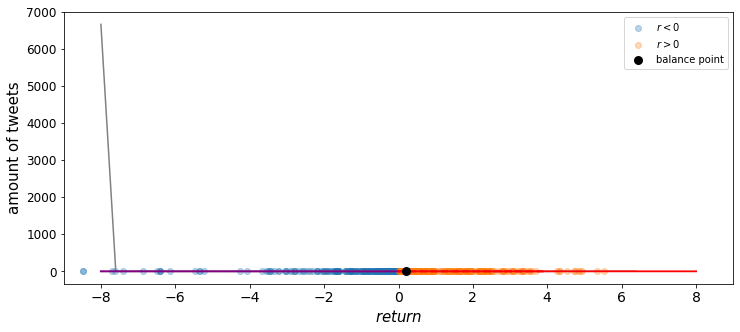

收益率为0： 0.7477512720960564
收益率为1： 0.07835669158047132
收益率为2： 7.785397669401232
收益率为4： 1.7893278406649236
收益率为6： 1.5589481232670388


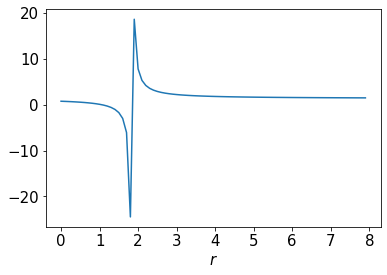

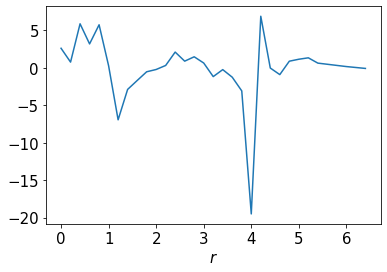

return > 0
[[Variables]]
    A1:  2.4898e-07 +/- 1.8879e-06 (758.28%) (init = 1000)
    A2:  9.41256144 +/- 4.42961103 (47.06%) (init = 1)
    b:  -0.07811593 +/- 0.05896275 (75.48%) (init = 4000)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -0.999
    C(A1, b)  = -0.194
    C(A2, b)  = 0.188
- * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - 
return < 0
[[Variables]]
    A1:  0.52648580 +/- 0.72901573 (138.47%) (init = 0.1071657)
    A2:  0.33730265 +/- 0.44123947 (130.81%) (init = 1.5)
    b:  -0.47516322 +/- 0.67469075 (141.99%) (init = -0.1125506)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, b)  = -0.993
    C(A1, A2) = -0.966
    C(A2, b)  = 0.953


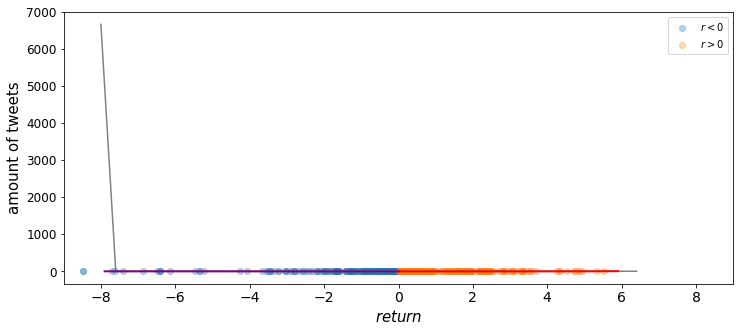

收益率为0.5： 0.748109607268927
收益率为1： -0.6570074399465327
收益率为2： -2.4375112820122924
收益率为4： 9.733651214649411
收益率为6： 0.09433687517625065


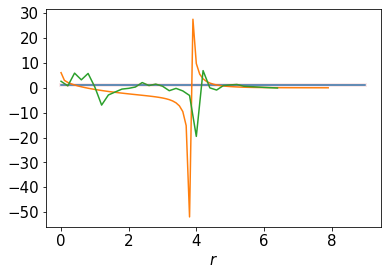

In [31]:
print("收益率与topic0_zscore")
x_n = topic_z.close0[topic_z.close0<0]
y_n = topic_z.topic0_zscore[topic_z.close0<0]
x = topic_z.close0[topic_z.close0>0]
y = topic_z.topic0_zscore[topic_z.close0>0]
my_analysis(x_n, y_n, x, y, hi='Kay')

pass

收益率与topic1_zscore
return > 0
---------- 收益率 < 0 ----------
相关性： -0.31572304096843723
参数： -0.18422895109826148 -0.20056830654033966
R^2： 0.09968103859835742
[[Variables]]
    k: -0.18422895 +/- 0.04038042 (21.92%) (init = 1000)
    b: -0.20056831 +/- 0.10008774 (49.90%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = 0.658
---------- 收益率 > 0 ----------
相关性： 0.2448316203474539
参数： 0.18070141277308366 -0.3199550838734579
R^2： 0.05994252232195996
[[Variables]]
    k:  0.18070141 +/- 0.04544074 (25.15%) (init = -1000)
    b: -0.31995509 +/- 0.08349035 (26.09%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = -0.735
- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -
斜率比例： -1.0195213655003768
平衡点： 0.3271494760441682


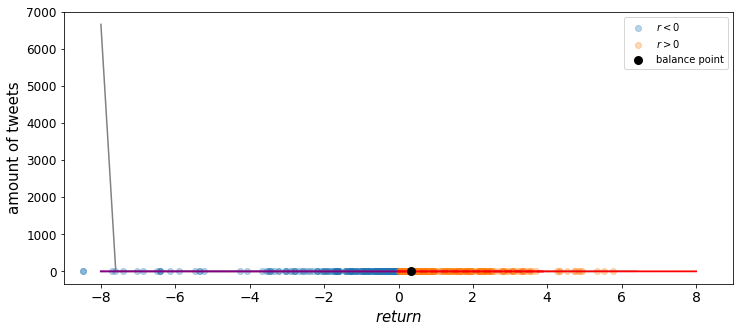

收益率为0： 0.6268639463771245
收益率为1： 0.11733518630399876
收益率为2： 4.050633131761854
收益率为4： 1.3313807686940602
收益率为6： 1.1839076000378261


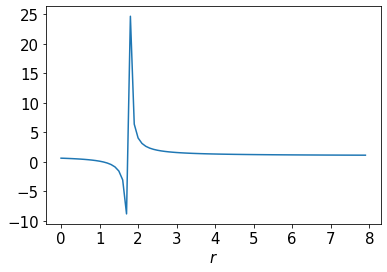

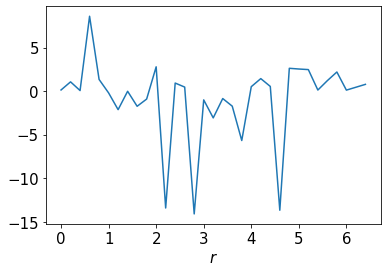

return > 0
[[Variables]]
    A1:  1.2881e-06 +/- 7.0780e-06 (549.50%) (init = 1000)
    A2:  8.35635133 +/- 3.21430082 (38.47%) (init = 1)
    b:  -0.12225455 +/- 0.05816392 (47.58%) (init = 4000)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -0.999
    C(A1, b)  = -0.213
    C(A2, b)  = 0.206
- * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - 
return < 0
[[Variables]]
    A1:  0.23045840 +/- 0.20433976 (88.67%) (init = 0.184229)
    A2:  0.88823618 +/- 0.42809100 (48.20%) (init = 1.5)
    b:  -0.23716975 +/- 0.18774111 (79.16%) (init = -0.2005683)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -0.969
    C(A1, b)  = -0.898
    C(A2, b)  = 0.826


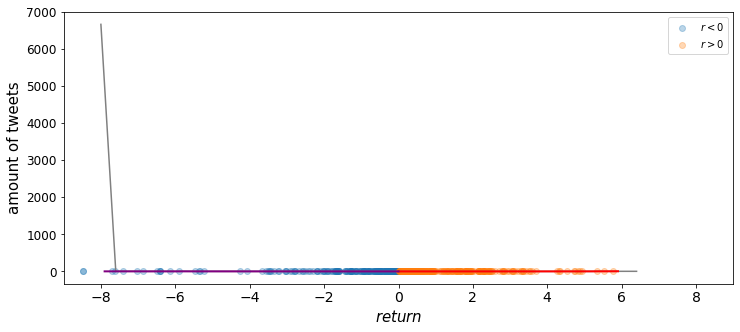

收益率为0.5： 0.9215118454314397
收益率为1： 0.054897079980964755
收益率为2： -1.55449971223222
收益率为4： 34.321770361945276
收益率为6： 0.2250888254322263


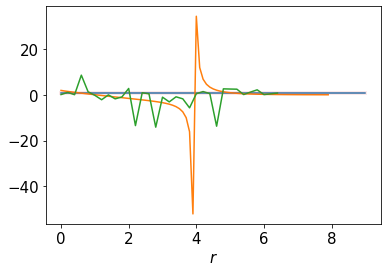

In [32]:
print("收益率与topic1_zscore")
x_n = topic_z.close1[topic_z.close1<0]
y_n = topic_z.topic1_zscore[topic_z.close1<0]
x = topic_z.close1[topic_z.close1>0]
y = topic_z.topic1_zscore[topic_z.close1>0]
my_analysis(x_n, y_n, x, y, hi='Kay')

pass

收益率与topic2_zscore
return > 0
---------- 收益率 < 0 ----------
相关性： 0.1357508162866898
参数： 0.0665864295700351 0.16344490721730504
R^2： 0.018428284122502525
[[Variables]]
    k:  0.06658643 +/- 0.03878417 (58.25%) (init = 1000)
    b:  0.16344491 +/- 0.09416268 (57.61%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = 0.643
---------- 收益率 > 0 ----------
相关性： -0.1197134298736718
参数： -0.10446829709470279 0.10644586949130425
R^2： 0.014331305292118457
[[Variables]]
    k: -0.10446829 +/- 0.06110955 (58.50%) (init = -1000)
    b:  0.10644587 +/- 0.11007623 (103.41%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = -0.742
- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -
斜率比例： -0.6373840813129465
平衡点： -0.3332210622727613


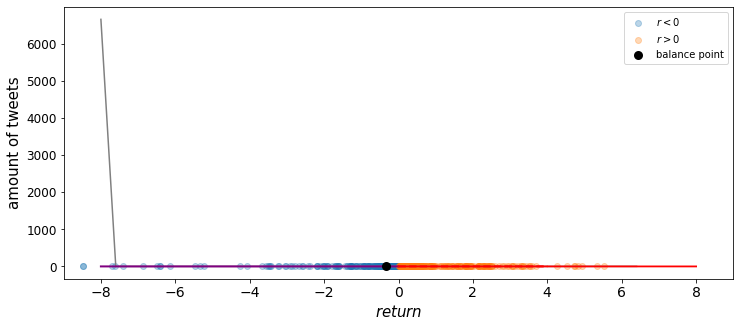

收益率为0： 1.5354743965021316
收益率为1： 48.97847371541258
收益率为2： -0.29536378210228054
收益率为4： 0.3304167772770281
收益率为6： 0.4536703339149744


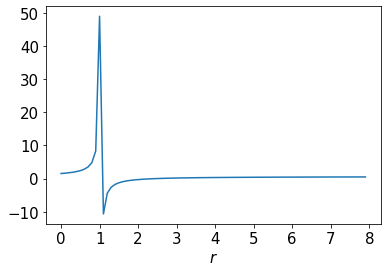

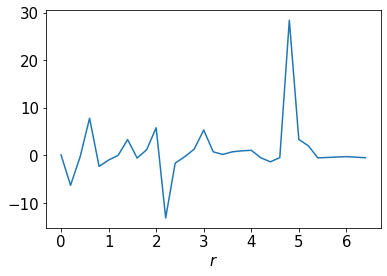

return > 0
[[Variables]]
    A1: -382.737464 +/- 494444.450 (129186.32%) (init = 1000)
    A2:  3.6861e-04 +/- 0.49281965 (133697.69%) (init = 1)
    b:   382.668494 +/- 494444.411 (129209.59%) (init = 4000)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, b)  = -1.000
    C(A2, b)  = -1.000
    C(A1, A2) = 1.000
- * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - 
return < 0
[[Variables]]
    A1: -0.25028947 +/- 0.47725960 (190.68%) (init = -0.06658643)
    A2:  0.44123198 +/- 0.71498374 (162.04%) (init = 1.5)
    b:   0.31979184 +/- 0.42929752 (134.24%) (init = 0.1634449)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, b)  = -0.985
    C(A1, A2) = 0.963
    C(A2, b)  = -0.935


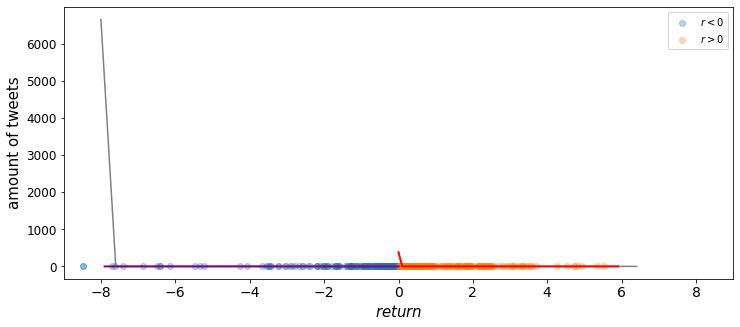

收益率为0.5： 4.702035945412601
收益率为1： -1.0077265290359572
收益率为2： 0.12017677247429971
收益率为4： 0.5352355058827153
收益率为6： 0.7209175170551361


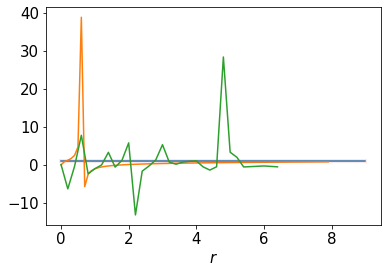

In [27]:
print("收益率与topic2_zscore")
x_n = topic_z.close[topic_z.close<0]
y_n = topic_z.topic2_zscore[topic_z.close<0]
x = topic_z.close[topic_z.close>0]
y = topic_z.topic2_zscore[topic_z.close>0]
my_analysis(x_n, y_n, x, y, hi='Kay')

pass

收益率与topic3_zscore
return > 0
---------- 收益率 < 0 ----------
相关性： 0.07048109618064469
参数： 0.04503545006877287 0.09993781488140376
R^2： 0.0049675849188254295
[[Variables]]
    k:  0.04503545 +/- 0.04831988 (107.29%) (init = 1000)
    b:  0.09993781 +/- 0.12289060 (122.97%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = 0.654
---------- 收益率 > 0 ----------
相关性： -0.022786461255835826
参数： -0.014048803348912505 -0.0009316588248264868
R^2： 0.0005192228165634694
[[Variables]]
    k: -0.01404880 +/- 0.04184270 (297.84%) (init = -1000)
    b: -9.3166e-04 +/- 0.07731116 (8298.21%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = -0.740
- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -
斜率比例： -3.205643139154552
平衡点： -1.7072141538821157


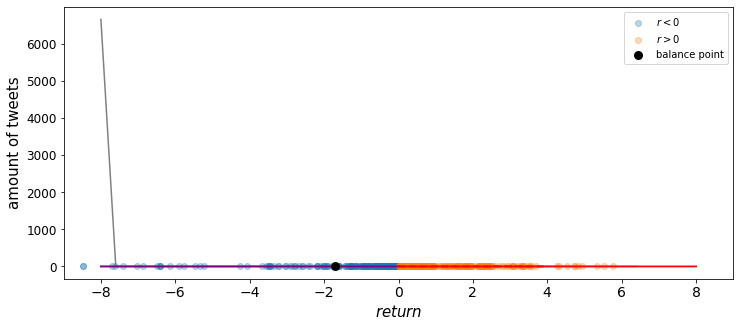

收益率为0： -107.26868271764215
收益率为1： -3.664931306917598
收益率为2： -0.33989543194466565
收益率为4： 1.4039624834376887
收益率为6： 1.9979574846619315


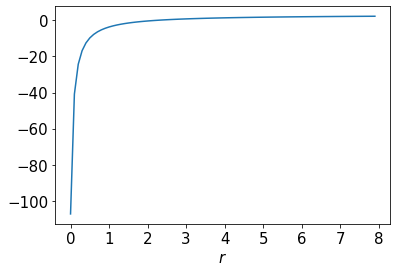

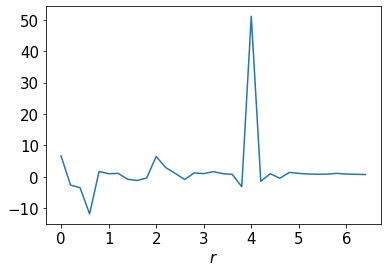

return > 0
[[Variables]]
    A1: -0.00635987 +/- 0.08184439 (1286.89%) (init = 1000)
    A2:  1.53901156 +/- 8.19405012 (532.42%) (init = 1)
    b:  -0.00652776 +/- 0.09124682 (1397.83%) (init = 4000)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = 0.973
    C(A1, b)  = -0.776
    C(A2, b)  = -0.692
- * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - 
return < 0
[[Variables]]
    A1: -0.01725832 +/- 0.11165199 (646.95%) (init = -0.04503545)
    A2:  1.51287955 +/- 3.25031369 (214.84%) (init = 1.5)
    b:   0.07894238 +/- 0.14852912 (188.15%) (init = 0.09993781)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = 0.987
    C(A1, b)  = -0.735
    C(A2, b)  = -0.685


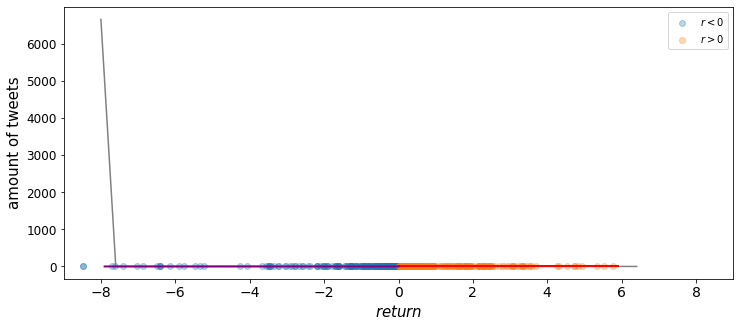

收益率为0.5： -8.363030969079054
收益率为1： -4.786300195811959
收益率为2： -1.1871900999138256
收益率为4： 1.0228676318690806
收益率为6： 1.6917755277474884


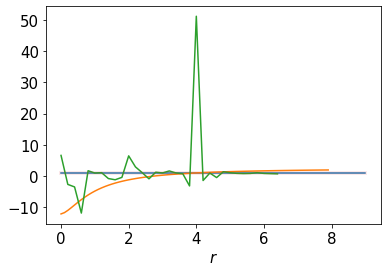

In [33]:
print("收益率与topic3_zscore")
x_n = topic_z.close3[topic_z.close3<0]
y_n = topic_z.topic3_zscore[topic_z.close3<0]
x = topic_z.close3[topic_z.close3>0]
y = topic_z.topic3_zscore[topic_z.close3>0]
my_analysis(x_n, y_n, x, y, hi='Kay')

pass

收益率与topic4_zscore
return > 0
---------- 收益率 < 0 ----------
相关性： -0.5118186692294464
参数： -0.28012090235167514 -0.2438320079883408
R^2： 0.261958350171801
[[Variables]]
    k: -0.28012090 +/- 0.03429185 (12.24%) (init = 1000)
    b: -0.24383201 +/- 0.08326480 (34.15%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = 0.651
---------- 收益率 > 0 ----------
相关性： 0.22341288152202804
参数： 0.17300375847183722 -0.383989437152887
R^2： 0.04991331562997592
[[Variables]]
    k:  0.17300376 +/- 0.04792952 (27.70%) (init = -1000)
    b: -0.38398944 +/- 0.08798927 (22.91%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = -0.734
- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -
斜率比例： -1.6191607906441825
平衡点： 0.30931317865115315


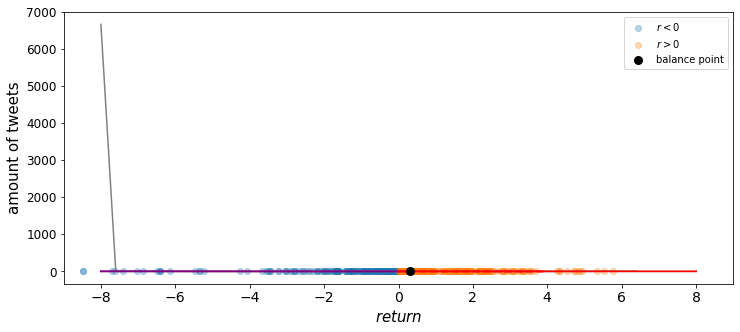

收益率为0： 0.6349966545857303
收益率为1： -0.17199695538668675
收益率为2： -8.330537133777234
收益率为4： 2.846034909800339
收益率为6： 2.196973480503063


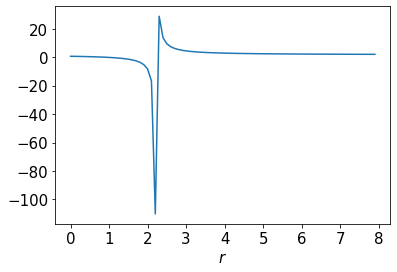

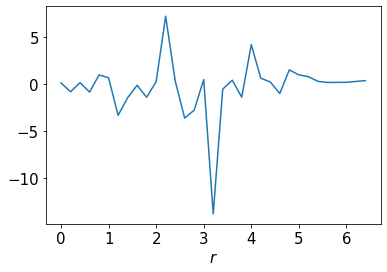

return > 0
[[Variables]]
    A1: -865.307540 +/- 5349799.48 (618254.12%) (init = 1000)
    A2: -9.0604e-05 +/- 0.58766342 (648605.89%) (init = 1)
    b:   865.177412 +/- 5349799.43 (618347.10%) (init = 4000)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, b)  = -1.000
    C(A2, b)  = 1.000
    C(A1, A2) = -1.000
- * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - 
return < 0
[[Variables]]
    A1:  0.06019624 +/- 0.04988630 (82.87%) (init = 0.2801209)
    A2:  1.81551363 +/- 0.41451920 (22.83%) (init = 1.5)
    b:  -0.06928255 +/- 0.08769588 (126.58%) (init = -0.243832)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -0.991
    C(A1, b)  = -0.660
    C(A2, b)  = 0.619


<ipython-input-8-db599998c420>:3: RuntimeWarning: divide by zero encountered in power
  return p['A1'] * (x ** p['A2']) + p['b']


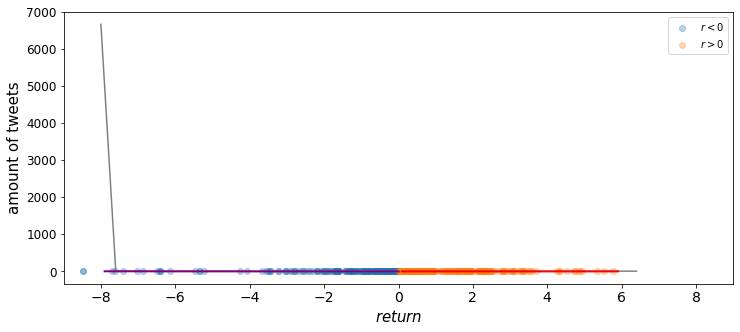

收益率为0.5： 0.28286347461463623
收益率为1： 0.06982593389848189
收益率为2： -1.8815834570867138
收益率为4： -31.54053821017573
收益率为6： 143.95565297140678


<ipython-input-8-db599998c420>:3: RuntimeWarning: divide by zero encountered in power
  return p['A1'] * (x ** p['A2']) + p['b']


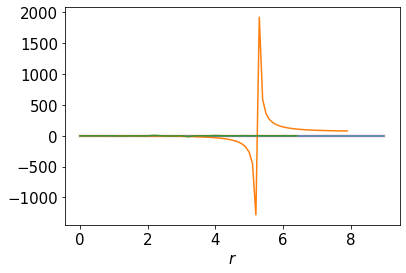

In [34]:
print("收益率与topic4_zscore")
x_n = topic_z.close4[topic_z.close4<0]
y_n = topic_z.topic4_zscore[topic_z.close4<0]
x = topic_z.close4[topic_z.close4>0]
y = topic_z.topic4_zscore[topic_z.close4>0]
my_analysis(x_n, y_n, x, y, hi='Kay')

pass

收益率与topic5_zscore
return > 0
---------- 收益率 < 0 ----------
相关性： -0.1725444394288597
参数： -0.09155945614173823 -0.15494258779888007
R^2： 0.029771583577819505
[[Variables]]
    k: -0.09155946 +/- 0.03801967 (41.52%) (init = 1000)
    b: -0.15494259 +/- 0.09377144 (60.52%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = 0.655
---------- 收益率 > 0 ----------
相关性： 0.1272834593568453
参数： 0.10324869162624076 -0.13169895602138634
R^2： 0.016201079025845777
[[Variables]]
    k:  0.10324869 +/- 0.05182714 (50.20%) (init = -1000)
    b: -0.13169896 +/- 0.09431969 (71.62%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = -0.730
- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -
斜率比例： -0.8867856308841429
平衡点： -0.11931550114206427


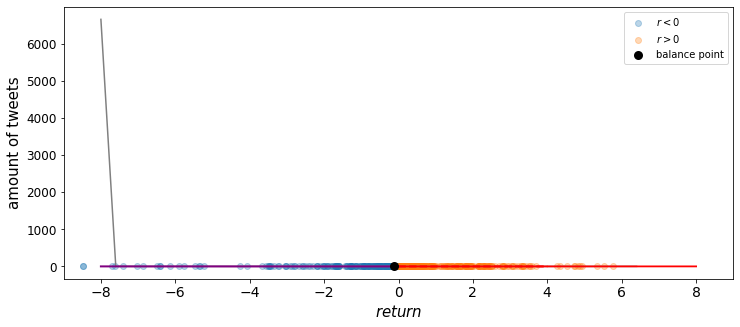

收益率为0： 1.1764906304475127
收益率为1： 2.2278573856753603
收益率为2： 0.37669675055524354
收益率为4： 0.7511496044140666
收益率为6： 0.8085683730654191


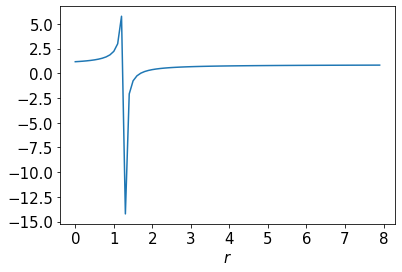

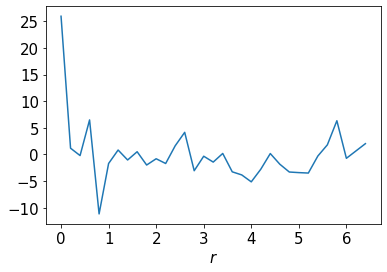

return > 0
[[Variables]]
    A1:  0.22868085 +/- 0.39852155 (174.27%) (init = 1000)
    A2:  0.55446150 +/- 0.86854449 (156.65%) (init = 1)
    b:  -0.23262635 +/- 0.34697483 (149.16%) (init = 4000)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, b)  = -0.981
    C(A1, A2) = -0.962
    C(A2, b)  = 0.927
- * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - 
return < 0
[[Variables]]
    A1:  0.61393578 +/- 1.04175936 (169.69%) (init = 0.09155946)
    A2:  0.24998262 +/- 0.42513600 (170.07%) (init = 1.5)
    b:  -0.61692728 +/- 0.99064284 (160.58%) (init = -0.1549426)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, b)  = -0.997
    C(A1, A2) = -0.977
    C(A2, b)  = 0.972


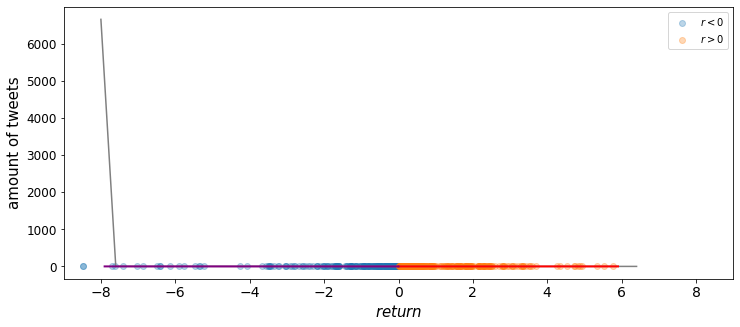

收益率为0.5： 1.308777995685867
收益率为1： 0.7582063159268826
收益率为2： 1.0963167547137438
收益率为4： 0.9642565025263524
收益率为6： 0.8933933731082736


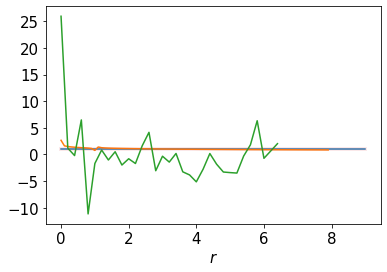

In [35]:
print("收益率与topic5_zscore")
x_n = topic_z.close5[topic_z.close5<0]
y_n = topic_z.topic5_zscore[topic_z.close5<0]
x = topic_z.close5[topic_z.close5>0]
y = topic_z.topic5_zscore[topic_z.close5>0]
my_analysis(x_n, y_n, x, y, hi='Kay')

pass